# Neutralization assays of HAARVI sera versus WT and mutant spike-pseudotyped lentiviruses

Andrea (with some help from me) cloned these mutants and she made spike-PV lentivirus. 
Andrea set up most of the neuts, with help from me on a few things here and there. 

She started each sample at a slightly different initial dilution to capture the full neutralization curve for each sample, given that each serum has a different neutralization potency (determined in Kate's original paper).

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Import modules

In [1]:
import itertools
import math
import os
import re
import warnings
import xml.etree.ElementTree as ElementTree

from IPython.display import display, HTML
from IPython.display import display, SVG
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import natsort
import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import svgutils

import yaml

In [2]:
warnings.simplefilter('ignore')

In [3]:
plt.style.use('seaborn-white')
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
#theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))

### Create results directory

In [4]:
resultsdir='results/mutant_neuts_results/'
os.makedirs(resultsdir, exist_ok=True)

Read config file

In [5]:
with open('mutant_neuts_config.yaml') as f:
    config = yaml.safe_load(f)
    
with open ('../config.yaml') as f:
    global_config = yaml.safe_load(f)

## Read in escape fractions

In [6]:
escape_fracs_file = os.path.join('..', global_config['escape_fracs'])
escape_fracs = pd.read_csv(escape_fracs_file).query('library == "average"')
escape_fracs.head()

escape_metrics = ['mut_escape_frac_epistasis_model',
                  'site_total_escape_frac_epistasis_model',
                  'site_avg_escape_frac_epistasis_model',
                 ]

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [7]:
frac_infect = pd.DataFrame() # create empty data frame

if config['neut_samples_ignore']:
    neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
#         .query('serum not in @neut_samples_ignore') # currently none in config
        .replace({'serum' : config['display_names']})
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

# below deals with samples / dates/ dilutions to ignore, which are currently none

# for s in config['neut_ignore_dilutions']:
#     dil = config['neut_ignore_dilutions'][s]
#     l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['concentration'] == dil)]))
#     print(f"Dropping {l} rows")
#     frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['concentration'] == dil))].index)
#     print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

# for s in config['neut_ignore_dates']:
#     dat = config['neut_ignore_dates'][s]
#     l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['date'] == dat)]))
#     print(f"Dropping {l} rows")
#     frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['date'] == dat))].index)
#     print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

frac_infect.head(2)

Length before dropping anything = 1288
Length after dropping neut_samples_ignore = 1288


,serum,virus,replicate,concentration,fraction infectivity,date
0,1C_d26,WT,1,0.025000,0.005157,201106
1,1C_d26,WT,1,0.008333,0.042560,201106


### Use `neutcurve` to fit Hill curves to data.
Get IC50 and calculate NT50. 
Determine if IC50 is bound.

In [8]:
for d in frac_infect['date'].unique():
    print(d)

201106
201116
201119
201221
201224


In [9]:
fitparams = pd.DataFrame(columns=['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date'])

for d in frac_infect['date'].unique():
    fits = neutcurve.CurveFits(frac_infect.query('date==@d'))

    fp = (
        fits.fitParams()
        .assign(NT50=lambda x: 1/x['ic50'],
                date=d
               )
        .replace({'WT':'wildtype'})
        # get columns of interest
        [['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date']] 
        )

    # couldn't get lambda / conditional statement to work with assign, so try it here:
    fp['ic50_is_bound'] = fp['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)
    fitparams=fitparams.append(fp, ignore_index=True)

fitparams.head()

,serum,virus,ic50,NT50,ic50_bound,date,ic50_is_bound
0,1C_d26,wildtype,0.000600,1666.929235,interpolated,201106,False
1,1C_d26,F456K,0.000871,1148.676778,interpolated,201106,False
2,1C_d26,E484P,0.002929,341.449922,interpolated,201106,False
3,1C_d113,wildtype,0.002278,438.988101,interpolated,201106,False
4,1C_d113,F456K,0.000863,1158.774452,interpolated,201106,False


### Calculate fold change for each mutant relative to wild type.

In [10]:
fc = (
    fitparams
    .query('virus != "wildtype"')
    .rename(columns={'virus': 'mutant'})
    .merge(fitparams.query('virus == "wildtype"')
                    [['serum', 'ic50', 'date']]
                    .rename(columns={'ic50': 'wildtype_ic50'}),
           on=['serum', 'date'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],
            log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2))
    )

fc.to_csv(f'{resultsdir}/mutants_foldchange_ic50.csv', index=False)
fc.head(3)

,serum,mutant,ic50,NT50,ic50_bound,date,ic50_is_bound,wildtype_ic50,fold_change,log2_fold_change
0,1C_d26,F456K,0.000871,1148.676778,interpolated,201106,False,0.000600,1.451173,0.537220
1,1C_d26,E484P,0.002929,341.449922,interpolated,201106,False,0.000600,4.881914,2.287447
2,1C_d113,F456K,0.000863,1158.774452,interpolated,201106,False,0.002278,0.378838,-1.400346


### Plot the raw neutralization curves

Saving to ./results/mutant_neuts_results//201116_mab_mutant_neuts.pdf
Saving to ./results/mutant_neuts_results//201106_sera_mutant_neuts.pdf
Saving to ./results/mutant_neuts_results//201116_sera_mutant_neuts.pdf
Saving to ./results/mutant_neuts_results//201119_sera_mutant_neuts.pdf
Saving to ./results/mutant_neuts_results//201221_sera_mutant_neuts.pdf
Saving to ./results/mutant_neuts_results//201224_sera_mutant_neuts.pdf
Curves not plotted for []


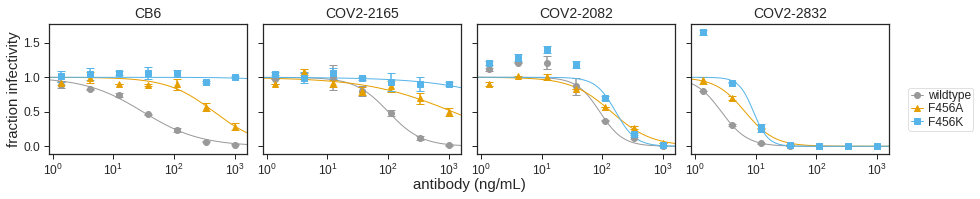

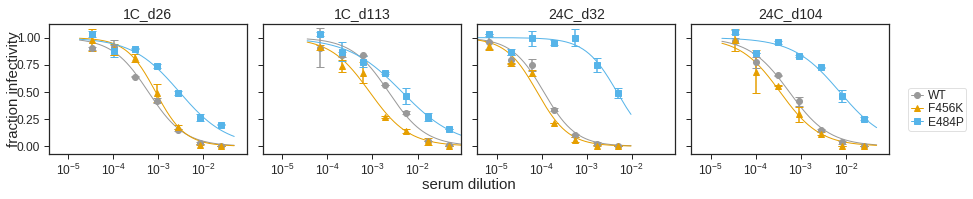

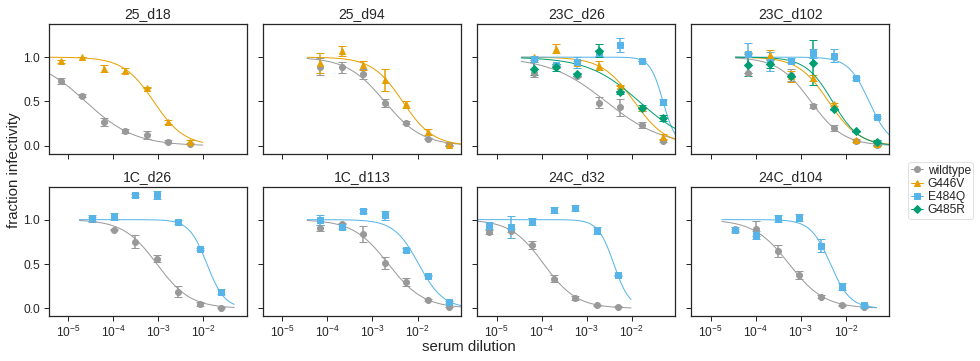

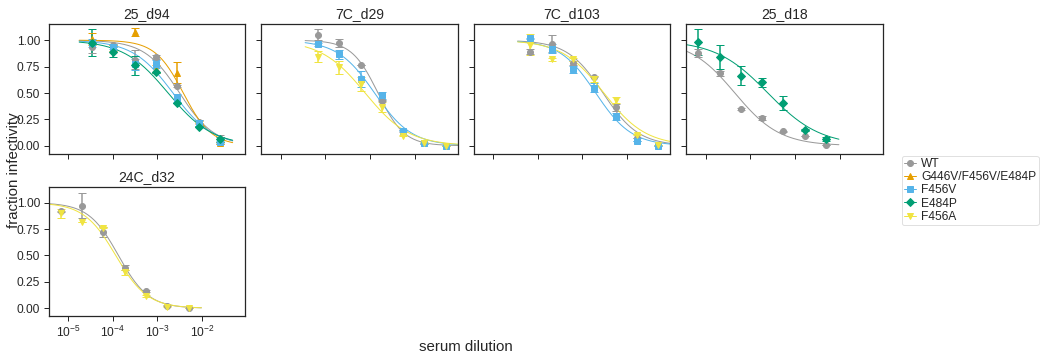

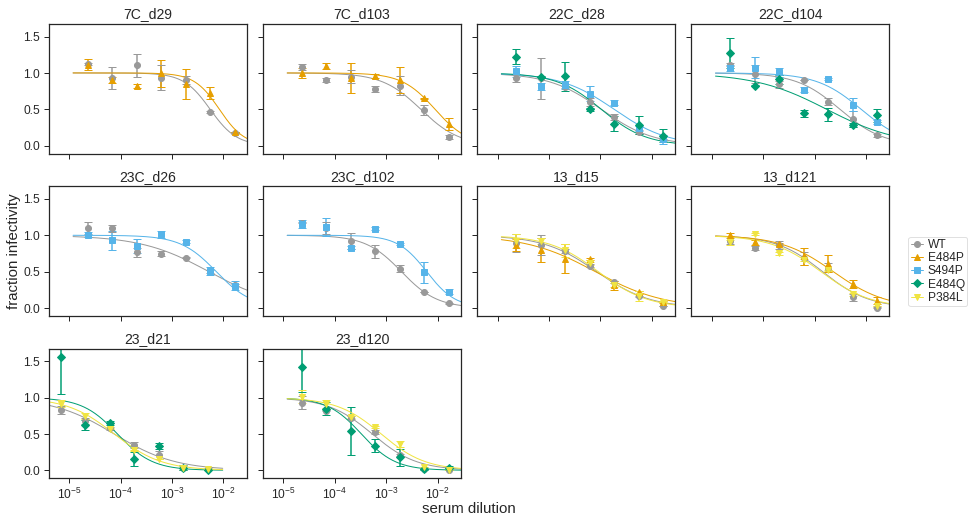

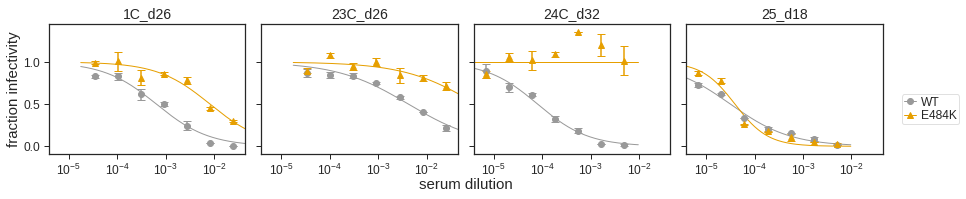

In [11]:
plotted_sera=[] # empty list we will use as a check to make sure we plot everything! 

for plot_grp in [config['antibody_controls'], config['serum_samples']]:
    for d in frac_infect['date'].unique():
        fits = neutcurve.CurveFits(frac_infect.query('date==@d & serum in @plot_grp'))
        xlab= 'antibody (ng/mL)' if plot_grp==config['antibody_controls'] else 'serum dilution'
        name= 'mab' if plot_grp==config['antibody_controls'] else 'sera'
        plotted_sera=plotted_sera + [s for s in plot_grp if s in fits.sera]
        
        if len([s for s in plot_grp if s in fits.sera])>=1:
            fig, axes = fits.plotSera(xlabel=xlab)

            plotfile = f'./{resultsdir}/{d}_{name}_mutant_neuts.pdf'
            print(f"Saving to {plotfile}")
            fig.savefig(plotfile, bbox_inches='tight')

excluded_sera = [s for s in fitparams['serum'] if s not in plotted_sera]
print(f"Curves not plotted for {excluded_sera}")

### Plot fold-change IC50 relative to wild type for each mutant.
You could also imagine drawing a dashed line with the fold-change with RBD depletion, which sets an upper limit on what we would expect to see (the max drop in NT50 we could see due to anything RBD-related). 

To do this you would need to:
* Read in foldchange IC50 due to RBD depletion (specify path in config file)
* Merge with mutant `foldchange` dataframe
* Add `geom_hline` with depletion foldchange

In [12]:
depletion_fc = (pd.read_csv(config['rbd_depletion_foldchange'])
                .drop(columns=['depletion', 'ic50', 'ic50_bound', 'ic50_is_bound', 'NT50', 'serum'])
                .drop_duplicates()
                .rename(columns={'fold_change':'depletion_fc'})
                .query('sample_group=="serum"')
               )

depletion_fc.head()
print(len(depletion_fc))

depletion_fc['dPSO_group'] = (depletion_fc['Days Post-Symptom Onset']
                                  .apply(lambda x: 'early' if x<=45 else 'late')
                                 )

foldchange = (fc.merge(depletion_fc,
                                    left_on=['serum'],
                                    right_on=['sample_name'],
                                    how='left',
                                    validate='many_to_one'
                                   )
             )

foldchange.head()

35


,serum,mutant,ic50,NT50,ic50_bound,date,ic50_is_bound,wildtype_ic50,fold_change,log2_fold_change,...,experiment,Sex,Age,Severity,IC50_D614,NT50_D614,logNT50_D614,logNT50_G614,max_fc,dPSO_group
0,1C_d26,F456K,0.000871,1148.676778,interpolated,201106,False,0.000600,1.451173,0.537220,...,expt_41,Male,35.0,Symptomatic Hospitalized,0.001594,627.425740,6.441625,7.354642,14.243019,early
1,1C_d26,E484P,0.002929,341.449922,interpolated,201106,False,0.000600,4.881914,2.287447,...,expt_41,Male,35.0,Symptomatic Hospitalized,0.001594,627.425740,6.441625,7.354642,14.243019,early
2,1C_d113,F456K,0.000863,1158.774452,interpolated,201106,False,0.002278,0.378838,-1.400346,...,expt_51,Male,35.0,Symptomatic Hospitalized,0.008034,124.464922,4.824024,5.651999,14.243019,late
3,1C_d113,E484P,0.004507,221.895200,interpolated,201106,False,0.002278,1.978358,0.984303,...,expt_51,Male,35.0,Symptomatic Hospitalized,0.008034,124.464922,4.824024,5.651999,14.243019,late
4,24C_d32,F456K,0.000080,12569.984770,interpolated,201106,False,0.000112,0.711198,-0.491677,...,expt_35,Female,76.0,Symptomatic Non-Hospitalized,0.000174,5761.315215,8.658921,8.154701,125.366727,early


Not plotting results for ['CB6', 'CB6', 'COV2-2165', 'COV2-2165', 'COV2-2082', 'COV2-2082', 'COV2-2832', 'COV2-2832']


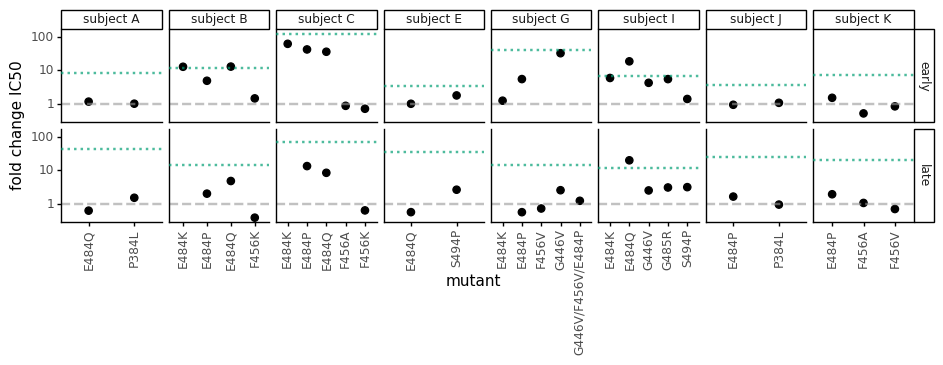

In [13]:
plot_sera = config["serum_samples"]
excluded_sera=[s for s in foldchange['serum'] if s not in plot_sera]
print(f'Not plotting results for {excluded_sera}')

p = (ggplot(foldchange
            .query("serum in @plot_sera")
            ) +
     aes('mutant', 'fold_change', 
        ) +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_grid('dPSO_group~display_PID', scales='free_x') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(1 * foldchange['mutant'].nunique(), 2.5),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(aes(yintercept='depletion_fc'),
                color=CBPALETTE[3],
                alpha=0.7,
                size=1,
                linetype='dotted',
               ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

# plotfile = f'{resultsdir}/fold_change_IC50_earlylate.pdf'
# print(f"Saving to {plotfile}")
# p.save(plotfile, verbose=False)

Create plot just for antibody controls here:

Saving to results/mutant_neuts_results//fold_change_IC50_antibodies.pdf


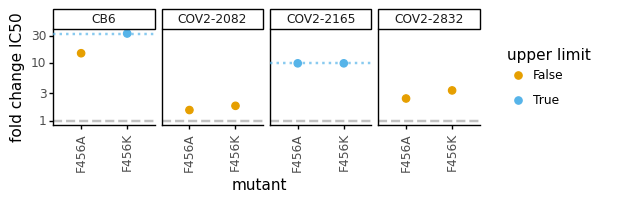

In [14]:
antibody_controls = config['antibody_controls']

upper_bound = (
    foldchange
    .query('ic50_bound == "lower" & serum in @antibody_controls')
    [['serum', 'fold_change']]
    .drop_duplicates()
    )
assert len(upper_bound) == upper_bound['serum'].nunique()

p = (ggplot(foldchange
            .query("serum in @antibody_controls")
            .assign(ic50_is_bound=lambda x: x['ic50_is_bound'],
                    )
            ) +
     aes('mutant', 'fold_change', color='ic50_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_grid('~serum', scales='free') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * foldchange['mutant'].nunique(), 1.25),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=upper_bound,
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[2],
                alpha=0.7,
                size=1,
                linetype='dotted',
                ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50_antibodies.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Now plot everything altogether

Saving to results/mutant_neuts_results//fold_change_IC50.pdf


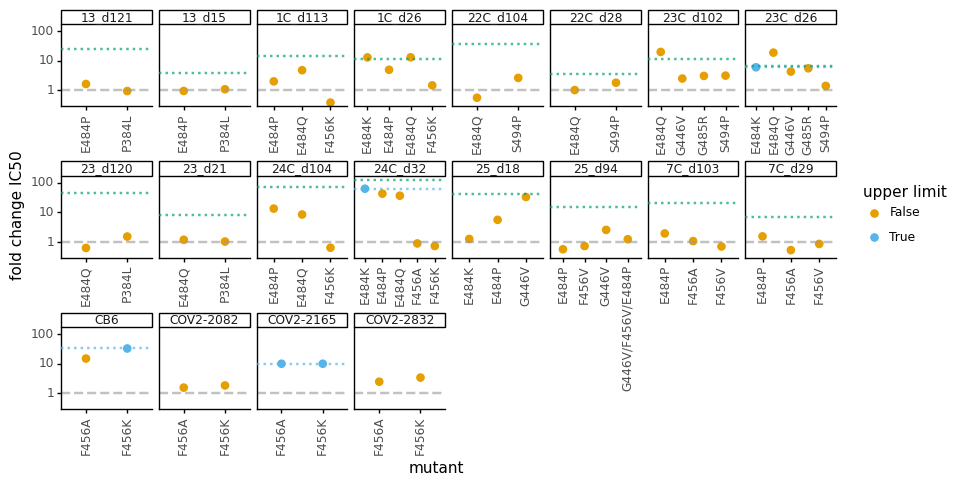

In [15]:
upper_bound = (
    foldchange
    .query('ic50_bound == "lower"')
    [['serum', 'fold_change']]
    .drop_duplicates()
    )
assert len(upper_bound) == upper_bound['serum'].nunique()

ncol=min(8, foldchange['serum'].nunique())
nrow= math.ceil(foldchange['serum'].nunique() / ncol)

p = (ggplot(foldchange
            .assign(ic50_is_bound=lambda x: x['ic50_is_bound'],
                    )
            ) +
     aes('mutant', 'fold_change', color='ic50_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_wrap('~serum', scales='free_x', ncol=ncol,) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(ncol*1.25, foldchange['serum'].nunique()*0.25),
           subplots_adjust={'hspace':0.85}
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=upper_bound,
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[2],
                alpha=0.7,
                size=1,
                linetype='dotted',
                ) +
     geom_hline(aes(yintercept='depletion_fc'),
                color=CBPALETTE[3],
                alpha=0.7,
                size=1,
                linetype='dotted',
               ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

## Make plots with escape fractions and fold-change IC50.

Define general function for making violin plots of escape combined with fold-change IC50s for all sera:

In [16]:
def day_labeller(old_label):
    new_label = f'day {old_label}'
    return(new_label)

def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile)
                            .getroot().attrib[dim]
                            .replace('px', '')
                            .replace('pt', '')
                            )

def accessible_down(mutant):
    """Is mutation accessible in down conformation?"""
    if re.search('446|484|485|494', mutant):
        return 'yes'
    elif re.search('384|456', mutant):
        return 'no'
    else:
        raise ValueError(f"no up/down accessibility info for {mutant}")

def make_escape_and_ic50_plot(escape_metric,
                              output_svg,
                              escape_ymax,
                              ylabel,
                              ):
    svgs = {}
    for subject, subj_df in foldchange.query('sample_group == "serum"').groupby('display_PID'):
    
        ic50s = subj_df[['serum', 'mutant', 'fold_change']]
    
        subject_df = (subj_df[['serum', 'depletion_fc', 
                               'sample', 'Participant ID', 'Days Post-Symptom Onset',
                               'sample_name', 'display_PID', 'display_name',
                               ]]
                      .drop_duplicates()
                      .assign(day=lambda x: x['Days Post-Symptom Onset'].astype(int))
                      )
        if isinstance(escape_ymax, dict):
            violin_ymax = max([escape_ymax[display_name]
                               for display_name in subject_df['display_name'].unique()])
        else:
            violin_ymax = escape_ymax
    
        # get escape fracs for this subject dealing with fact that selections
        # have additional underscore giving concentration
        serum_to_selection = {}
        for serum in subject_df['serum'].tolist():
            selection = [s for s in escape_fracs['selection'].unique() if re.fullmatch(f"{serum}_\d+", s)]
            assert len(selection) == 1, f"for serum {serum} did not find 1 selection:\n{selection}"
            serum_to_selection[serum] = selection[0]
    
        # get data frame with escape fractions for just this subject, indicating which mutations
        # have fold change IC50
        df = (subject_df
              .assign(selection=lambda x: x['serum'].map(serum_to_selection))
              .merge(escape_fracs, how='left', on='selection', validate='one_to_many')
              .assign(mutant=lambda x: x['wildtype'] + x['label_site'].astype(str) + x['mutation'],
                      site_label=lambda x: x['wildtype'] + x['label_site'].astype(str),
                      )
              .merge(ic50s, how='left', on=['serum', 'mutant'], validate='one_to_one')
              .assign(day=lambda x: pd.Categorical(x['Days Post-Symptom Onset'], 
                                                   natsort.natsorted(x['day'].unique()), 
                                                   ordered=True),
                     )
              )
        
        # data frame with mutations with fold changes for this subject
        df_foldchange = (
            df
            .query('fold_change.notnull()')
            .sort_values('site')
            .assign(mutant=lambda x: pd.Categorical(x['mutant'], x['mutant'].unique(), ordered=True),
                    accessible_down=lambda x: pd.Categorical(x['mutant'].map(accessible_down),
                                                             ['no', 'yes'],
                                                             ordered=True)
                    )
            )
           
        if 'mut' in escape_metric:
            ptlabel = 'mutant'
        else:
            assert 'site' in escape_metric
            ptlabel = 'site_label'
            df = df[['display_PID', 'day', escape_metric, ptlabel]].drop_duplicates()

        # make violin plot
        violin = (ggplot(df) +
                  aes('day', escape_metric) +
                  geom_violin(color='gray', fill='gray', alpha=0.5, adjust=5) +
                  geom_jitter(data=df_foldchange[['day', escape_metric, ptlabel, 'accessible_down']].drop_duplicates(),
                              mapping=aes(color='accessible_down', shape='accessible_down'),
                              size=2,
                              height=0,
                              width=0.25,
                              alpha=1,
                              random_state=3,
                              ) +
                  geom_text(data=df_foldchange[['day', escape_metric, ptlabel, 'accessible_down']].drop_duplicates(),
                            mapping=aes(label=ptlabel, color='accessible_down'),
                            size=8,
                            adjust_text={'expand_points': (1.1, 1.15),
                                         'expand_text': (1.1, 1.15),
                                         }
                            ) +
                  expand_limits(y=(0, violin_ymax)) +
                  theme_matplotlib() +
                  theme(figure_size=(1.2 * df['day'].nunique(), 2.1),
                        strip_background=element_blank(),
                        axis_text_x=element_blank(),
                        axis_ticks_major_x=element_blank(),
                        legend_position='none',
                        axis_title_x=element_blank(),
                        ) +
                  scale_y_continuous(name=ylabel, 
                                     expand=(0.075, 0)) +
                  facet_wrap('~ day', scales='free_x', labeller=day_labeller) +
                  scale_color_manual(values=[CBPALETTE[5], CBPALETTE[6]], drop=False) +
                  scale_shape_manual(values=['^', 'o'], drop=False)
                  )
        violin_svg = os.path.join(resultsdir, f"{subject.replace(' ', '_')}_violin_{escape_metric}.svg")
        violin.save(violin_svg, verbose=False)
    
        # make foldchange plot
        fc_df = (
            df_foldchange
            [['mutant', 'fold_change', 'day', 'depletion_fc']]
            .merge(ic50s[['mutant', 'fold_change', 'serum']]
                        .merge(df_foldchange[['serum', 'day', 'depletion_fc']].drop_duplicates()),
                   how='outer'
                   )
            .assign(accessible_down=lambda x: pd.Categorical(x['mutant'].map(accessible_down),
                                                             ['no', 'yes'],
                                                             ordered=True))
            )
        fc = (ggplot(fc_df) +
              aes('mutant', 'fold_change', color='accessible_down', shape='accessible_down') +
              geom_point(size=2) +
              theme_matplotlib() +
              theme(figure_size=(0.4 * len(df_foldchange), 1.9),
                    axis_text_x=element_text(angle=90, size=9),
                    strip_background=element_blank(),
                    legend_position='none',
                    axis_title_x=element_blank(),
                    ) +
              expand_limits(y=(0.5, 100)) +
              scale_y_log10(name='fold change IC50') +
              geom_hline(yintercept=1, color='gray', linetype='dashed', size=1, alpha=0.5) +
              geom_hline(aes(yintercept='depletion_fc'),
                         color=CBPALETTE[1],
                         alpha=0.7,
                         size=1,
                         linetype='dotted',
                         ) +
              facet_wrap('~ day', scales='free_x', labeller=day_labeller)  +
              scale_color_manual(values=[CBPALETTE[5], CBPALETTE[6]], drop=False) +
              scale_shape_manual(values=['^', 'o'], drop=False)
              )
        fc_svg = os.path.join(resultsdir, f"{subject.replace(' ', '_')}_fc_{escape_metric}.svg")
        fc.save(fc_svg, verbose=False)
    
        # assemble into a panel for this subject
        horiz_pad = 6
        title_pad = 5
        svg = os.path.join(resultsdir, f"{subject.replace(' ', '_')}.svg")
        width = svg_dim(violin_svg, 'width') + horiz_pad + svg_dim(fc_svg, 'width')
        svgutils.compose.Figure(
                width,
                max(svg_dim(violin_svg, 'height'), svg_dim(fc_svg, 'height')) + title_pad,
                svgutils.compose.Text(subject, width / 2 - horiz_pad, title_pad / 2, font='Arial', size=12),
                svgutils.compose.SVG(violin_svg).move(0, title_pad),
                svgutils.compose.SVG(fc_svg).move(svg_dim(violin_svg, 'width') + horiz_pad, title_pad)
                ).save(svg)
        svgs[subject] = svg
        
    # assemble into final SVG
    layout = [
        [('A', 'Mutations at 484 can have large effects on neutralization.'),
         'subject C',
         'subject B',
         ('B', 'Mutations at 446, 485, and 494 can also affect neutralization.'),
         'subject I',
         'subject E',
         'subject G',
         ],
        [('C', 'Some sera are unaffected by any single mutation.'),
         'subject J',
         'subject K',
         'subject A'
         ],
        ]
    fig_svgs = []  # build up this list of `svgutils.compose.SVG` objects
    fig_height = fig_width = 0
    height_pad = 25
    width_pad = 40
    for icol, col_list in enumerate(layout):
        col_height = 0
        col_width = 0
        for panel in col_list:
            if panel in svgs:
                svg = svgs.pop(panel)
                width = svg_dim(svg, 'width')
                height = svg_dim(svg, 'height')
                fig_svgs.append(svgutils.compose.SVG(svg).move(fig_width, col_height))
                col_height += height + height_pad
                col_width = max(col_width, width)
            else:
                (letter, title) = panel
                col_height += 20  # margin between vertical lettered panels
                fig_svgs.append(svgutils.compose.Text(letter, fig_width + 10, col_height,
                                                      font='Arial', size=16, weight='bold'))
                fig_svgs.append(svgutils.compose.Text(title, fig_width + 40, col_height,
                                                      font='Arial', size=14, weight='italic'))
                col_height += 16  # height of text
        fig_height = max(fig_height, col_height)
        fig_width += col_width + width_pad
    assert len(svgs) == 0, ValueError(f"still have some SVGs: {svgs}")
    svgutils.compose.Figure(fig_width, fig_height, *fig_svgs).save(output_svg)

Make the mutation-level plot:

In [ ]:
mut_fig_svg = os.path.join(resultsdir, 'validation_fig_mut.svg')
make_escape_and_ic50_plot(escape_metric='mut_escape_frac_epistasis_model',
                          output_svg=mut_fig_svg,
                          escape_ymax=0.4,
                          ylabel='escape fraction',
                          )
display(SVG(mut_fig_svg))

Make the site-level plot:

In [ ]:
sitetotal_fig_svg = os.path.join(resultsdir, 'validation_fig_sitetotal.svg')
make_escape_and_ic50_plot(escape_metric='site_total_escape_frac_epistasis_model',
                          output_svg=sitetotal_fig_svg,
                          escape_ymax=(pd.read_csv(config['ylim_file'])
                                       .set_index('condition')['maximum'].to_dict()
                                       ),
                          ylabel='total escape at site',
                          )
display(SVG(sitetotal_fig_svg))